<a href="https://colab.research.google.com/github/RudreshVeerkhare/Data_Science_Lab/blob/main/Time_Series_Analysis_(Exp_6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name - **Rudresh Veerkhare**  
UID - **2018130061**

**Traffic Prediction Dataset**  
Hourly traffic data on four different junctions

In [1]:
!gdown --id "16N4PCPs3i4WblXtQlgGru4zFHh_kvqWk" -O traffic.csv

Downloading...
From: https://drive.google.com/uc?id=16N4PCPs3i4WblXtQlgGru4zFHh_kvqWk
To: /content/traffic.csv
100% 1.77M/1.77M [00:00<00:00, 39.5MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(20, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data["Junction"].value_counts()

1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

For this experiement just considering datapoints for junction 1

In [4]:
df = data[data["Junction"] == 1][["DateTime", "Vehicles"]]
df["Time"] = np.arange(len(df.index))
df = df.drop("DateTime", axis = 1)
df.head()

,Vehicles,Time
0,15,0
1,13,1
2,10,2
3,7,3
4,9,4


## TimeStep Feature 
Time-step features are features we can derive directly from the time index.  
The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end. 

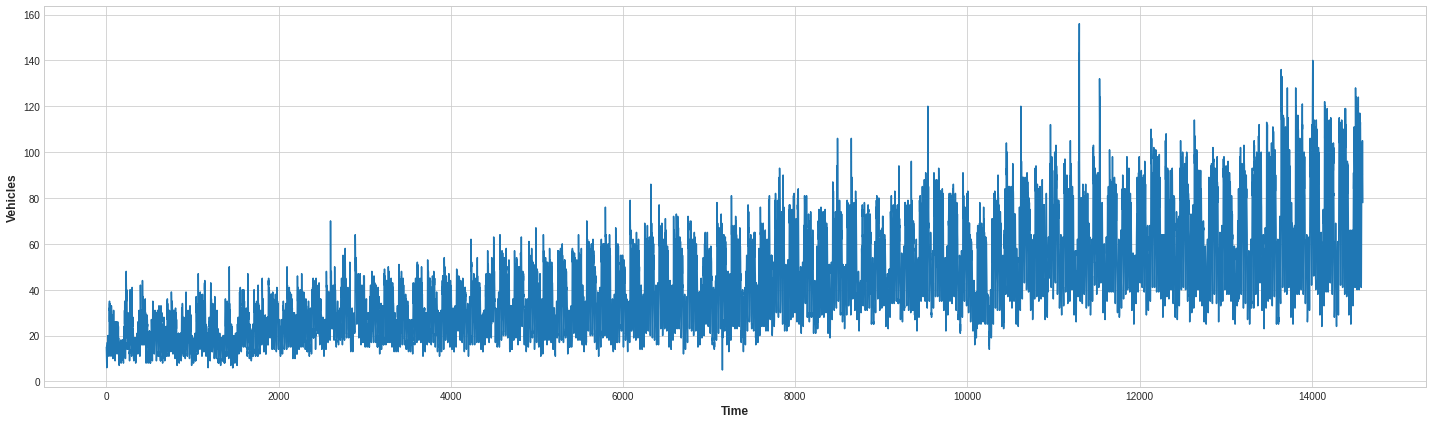

In [5]:
sns.lineplot(x = "Time", y = "Vehicles", data = df)

In [6]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'Vehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

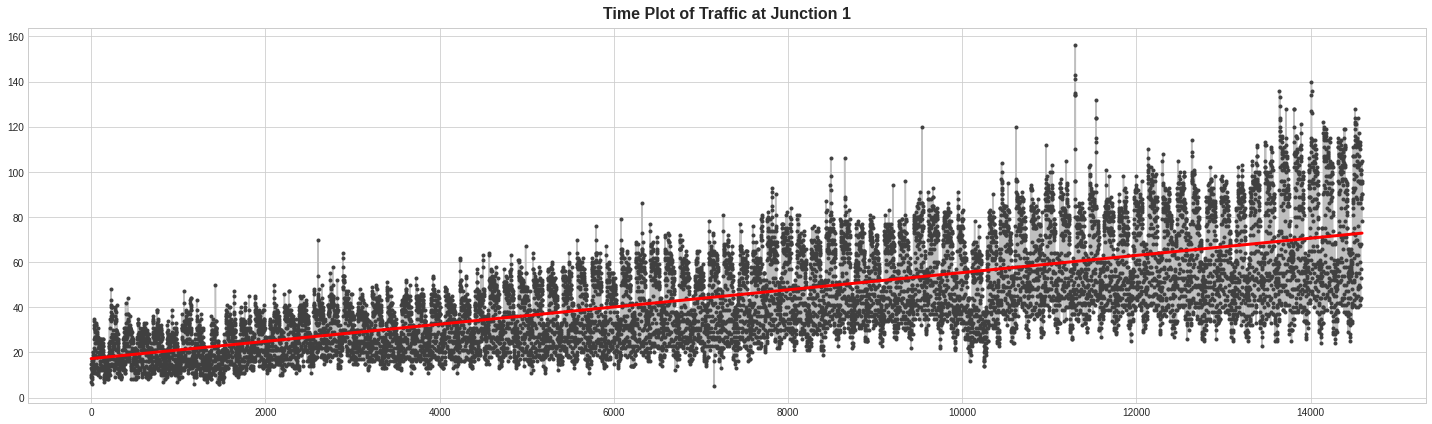

In [7]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, color = "red")
ax.set_title('Time Plot of Traffic at Junction 1');

Here an **upward trend** is can be seen

## Lag Feature
To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [8]:
df['Lag_1'] = df['Vehicles'].shift(1)
df.head()

,Vehicles,Time,Lag_1
0,15,0,NaN
1,13,1,15.0
2,10,2,13.0
3,7,3,10.0
4,9,4,7.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [9]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'Vehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

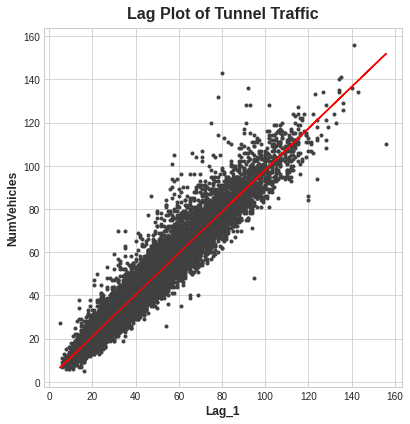

In [10]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred, color = "red")
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

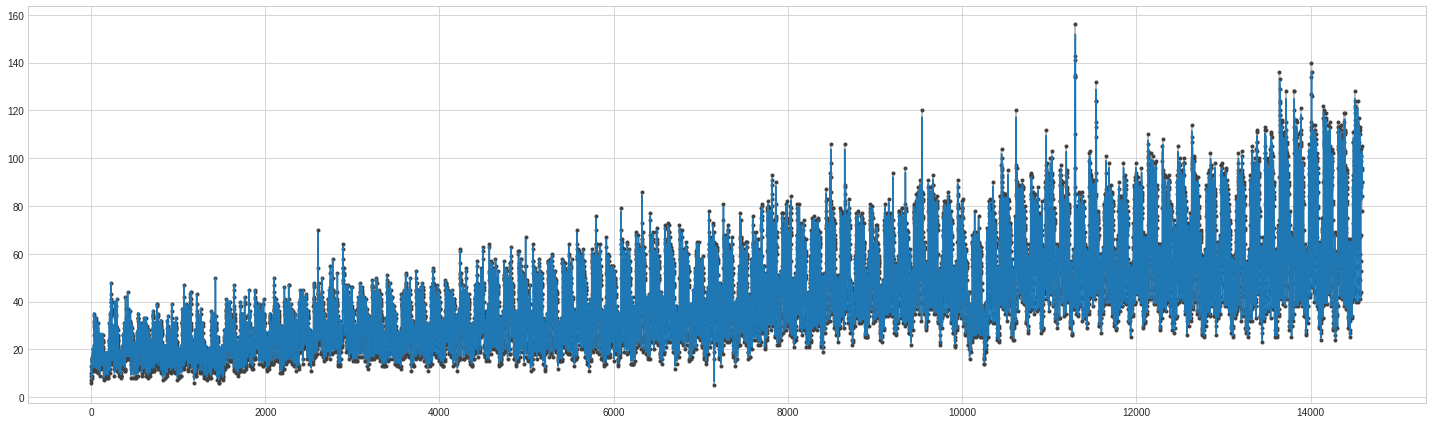

In [11]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## Trend
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

Let's make a moving average plot to see what kind of trend this series has. Since this series has hourly observations, let's choose a window of 24 hours to smooth over any short-term changes within a day.

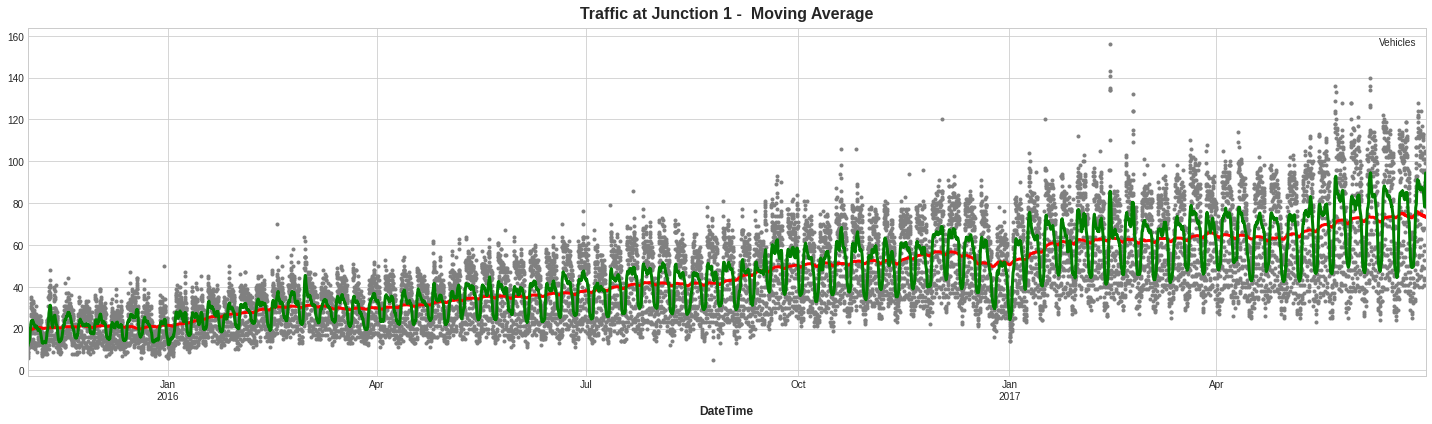

In [12]:
df_trend = data[data["Junction"] == 1][["DateTime", "Vehicles"]]
df_trend["DateTime"] = pd.to_datetime(df_trend["DateTime"])
df_trend = df_trend.set_index("DateTime").to_period()

moving_average_monthly = df_trend.rolling(
    window=24 * 30,       # monthly-day window
    center=True,      # puts the average at the center of the window
    min_periods=12 * 30,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

moving_average_daily = df_trend.rolling(
    window=24,       # monthly-day window
    center=True,      # puts the average at the center of the window
    min_periods=12,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


ax = df_trend.plot(style=".", color="0.5")
moving_average_monthly.plot(
    ax=ax, linewidth=3, legend=False, color = "red"
);
moving_average_daily.plot(
    ax=ax, linewidth=3, title="Traffic at Junction 1 -  Moving Average", legend=False, color = "green"
);

In [13]:
!pip install -U statsmodels 

     |████████████████████████████████| 9.8 MB 22.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.

In [14]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df_trend.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
DateTime,,
2015-11-01 00:00,1.0,1.0
2015-11-01 01:00,1.0,2.0
2015-11-01 02:00,1.0,3.0
2015-11-01 03:00,1.0,4.0
2015-11-01 04:00,1.0,5.0


In [15]:
from sklearn.linear_model import LinearRegression

y = df_trend["Vehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

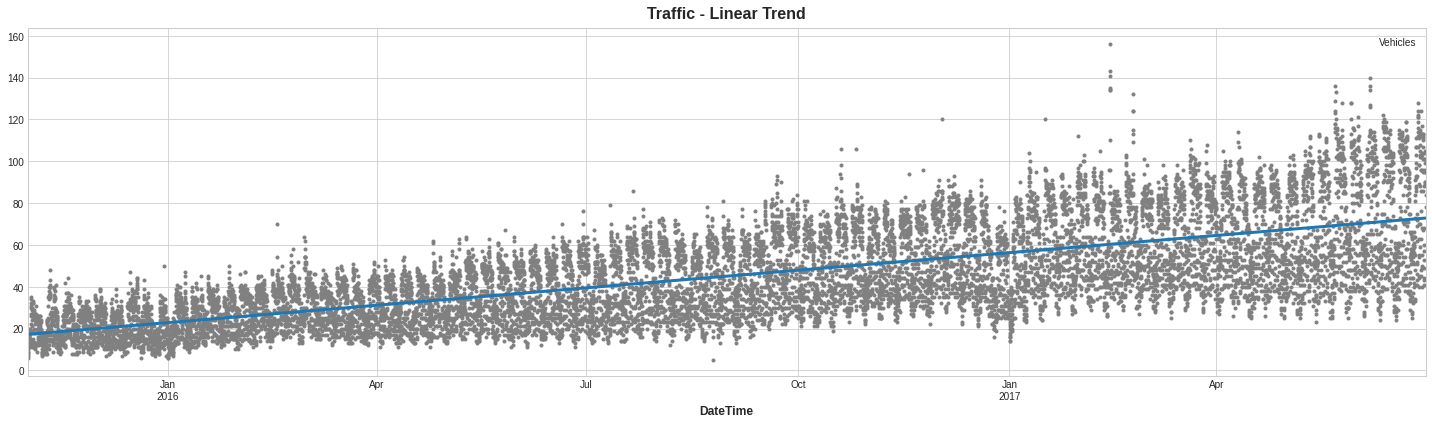

In [16]:
ax = df_trend.plot(style=".", color="0.5", title="Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [17]:
X = dp.out_of_sample(steps=100)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2017-07-01 00:00    72.850781
2017-07-01 01:00    72.854591
2017-07-01 02:00    72.858400
2017-07-01 03:00    72.862210
2017-07-01 04:00    72.866020
Freq: H, dtype: float64

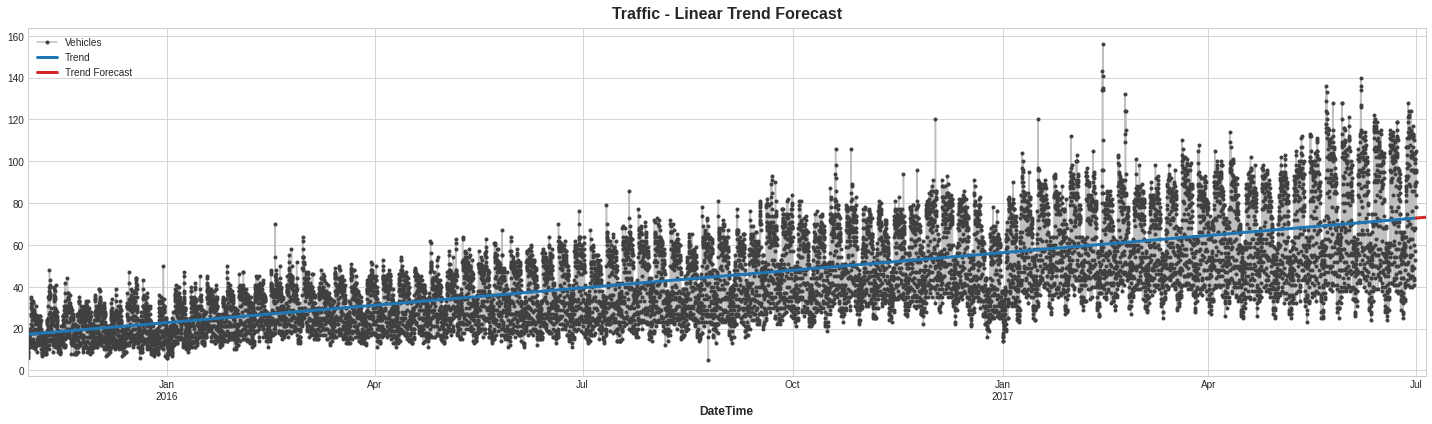

In [18]:
ax = df_trend.plot(title="Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

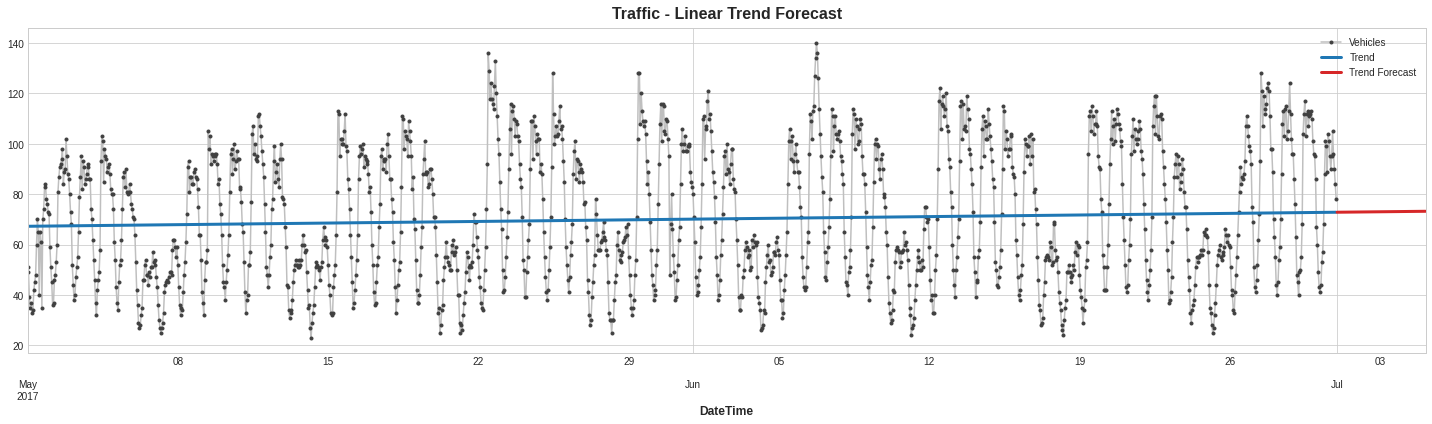

In [19]:
ax = df_trend["2017-05":].plot(title="Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2017-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Sesonality
We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

### Fourier Features
Fourier features try to capture the overall shape of the seasonal curve with just a few features.  
Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

In [20]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1h")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 4, 12, 52, 365])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Quarterly (4)",
            "Monthly (12)",
            "Weekly (52)",
            "Daily (365)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

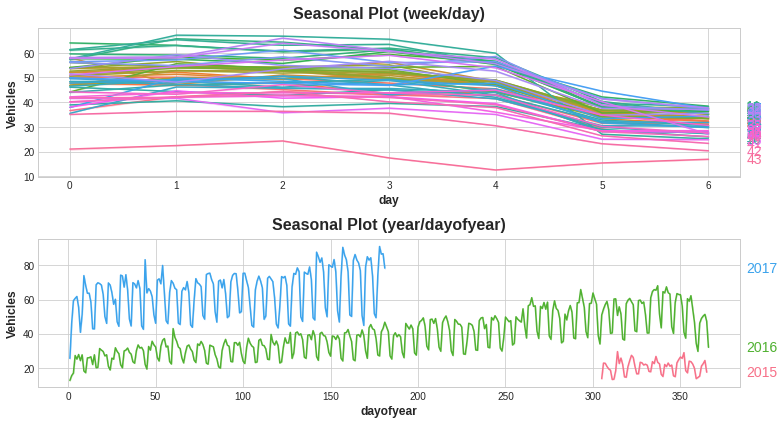

In [21]:
df_ses = data[data["Junction"] == 1][["DateTime", "Vehicles"]]
df_ses["DateTime"] = pd.to_datetime(df_ses["DateTime"])
df_ses = df_ses.set_index("DateTime").to_period()
# days within a week
df_ses["day"] = df_ses.index.dayofweek  # the x-axis (freq)
df_ses["week"] = df_ses.index.week  # the seasonal period (period)

# days within a year
df_ses["dayofyear"] = df_ses.index.dayofyear
df_ses["year"] = df_ses.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(df_ses, y="Vehicles", period="week", freq="day", ax=ax0)
seasonal_plot(df_ses, y="Vehicles", period="year", freq="dayofyear", ax=ax1);

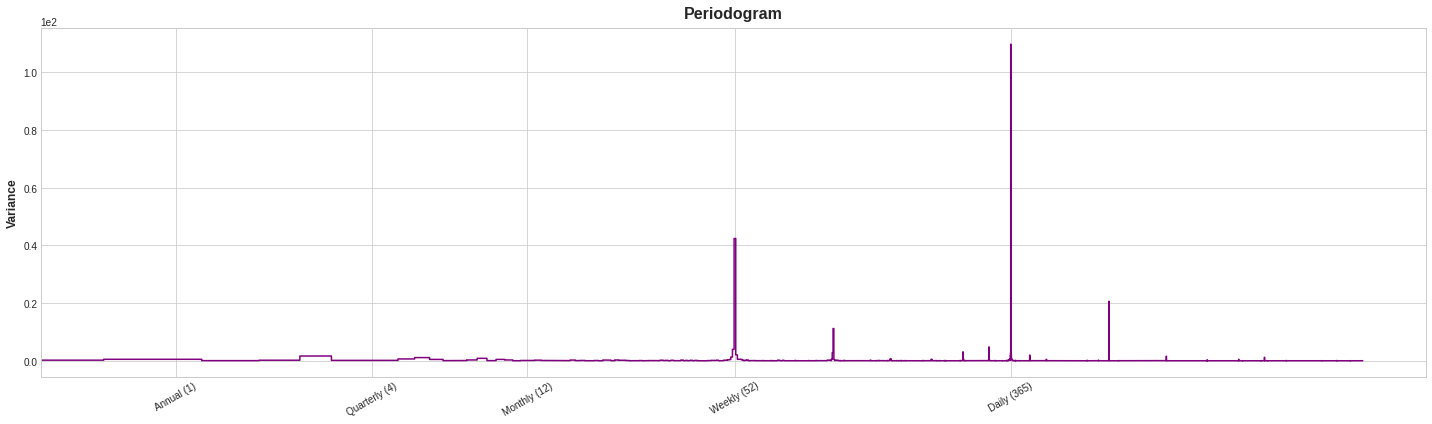

In [22]:
plot_periodogram(df_ses.Vehicles)

In [23]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="W", order=100)  # 10 sin/cos pairs for Weekly Seasonality

dp = DeterministicProcess(
    index=df_ses.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

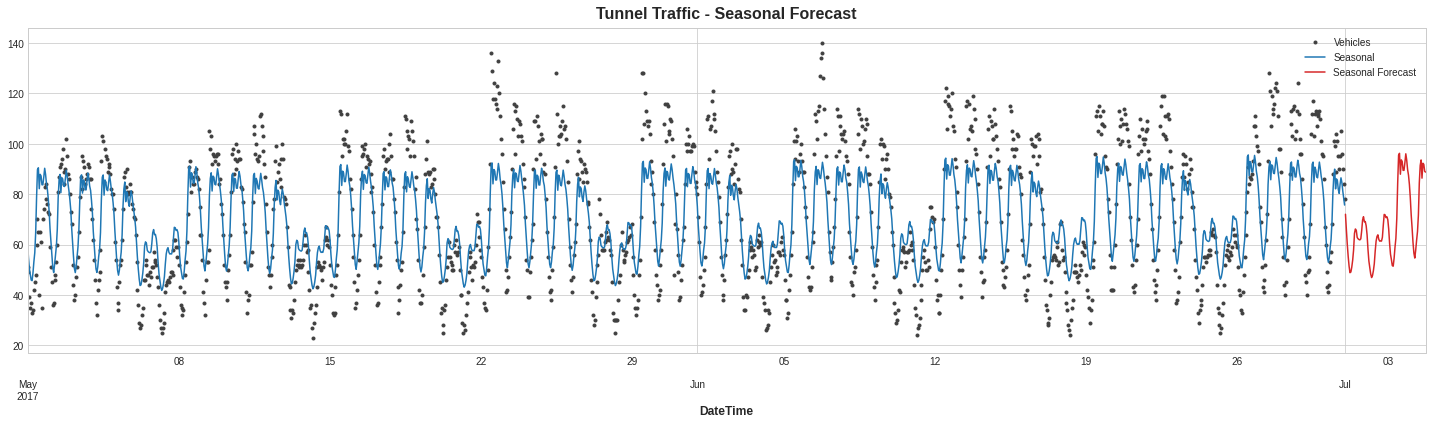

In [24]:
y = df_ses["Vehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y["2017-05":].plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred["2017-05":].plot(ax=ax, label="Seasonal")
ax = y_fore["2017-05":].plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

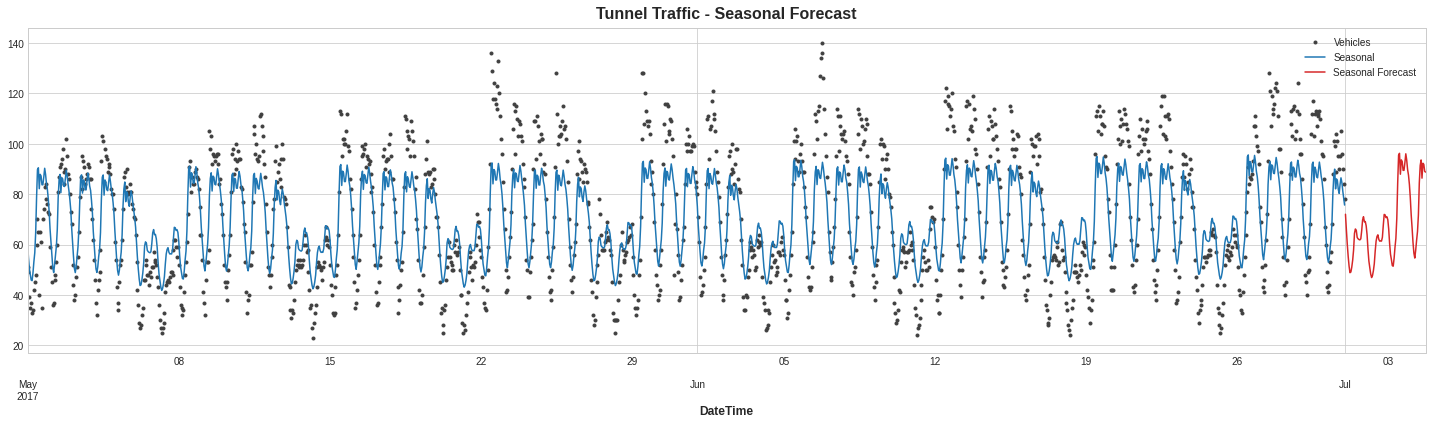

In [25]:
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y["2017-05":].plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred["2017-05":].plot(ax=ax, label="Seasonal")
ax = y_fore["2017-05":].plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

## Auto Correlation
The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use.

In [26]:
df_auto = data[data["Junction"] == 1][["DateTime", "Vehicles"]]

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


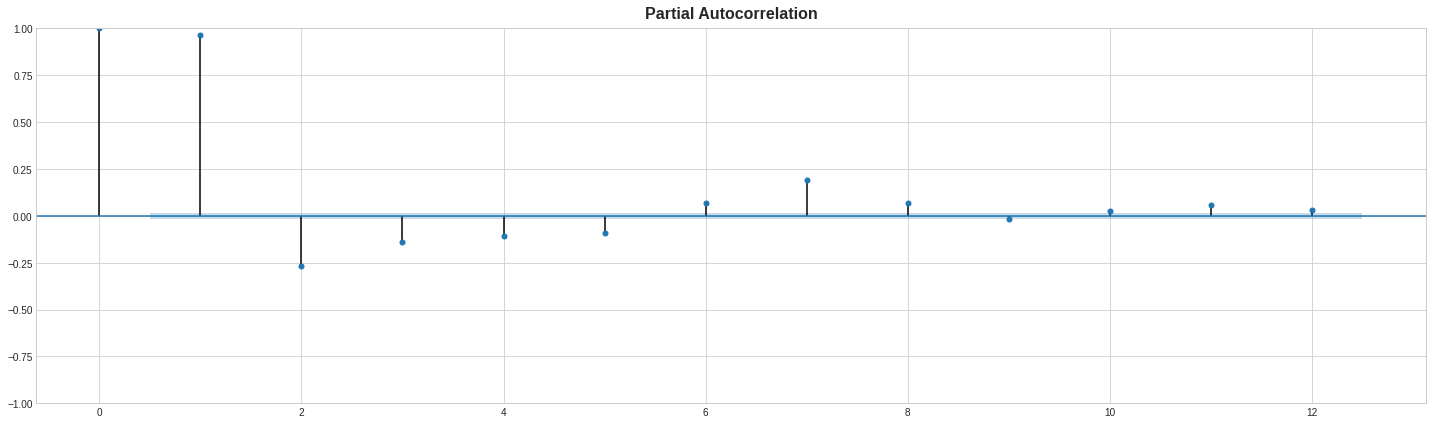

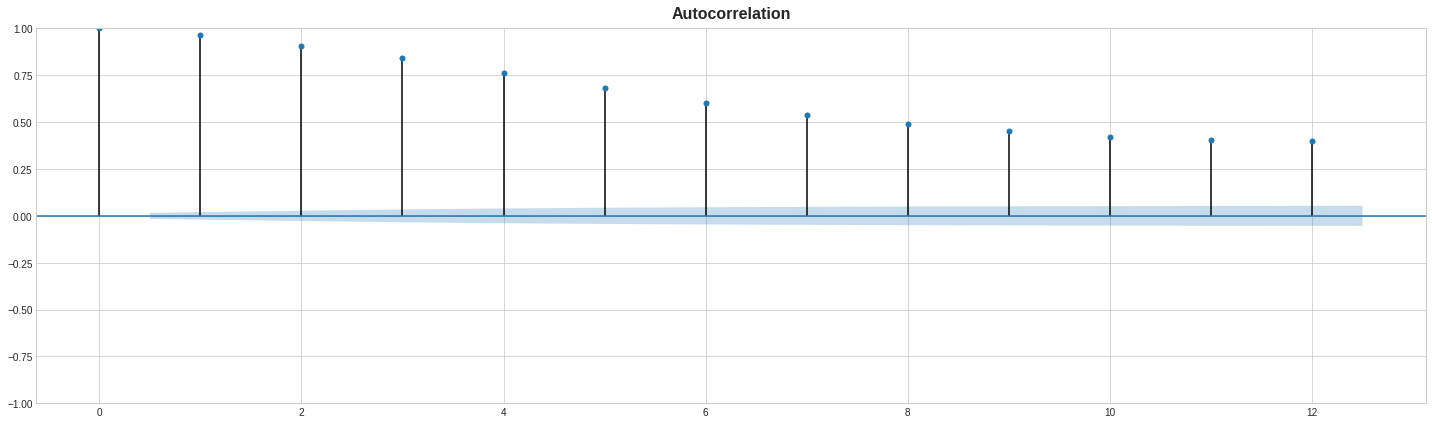

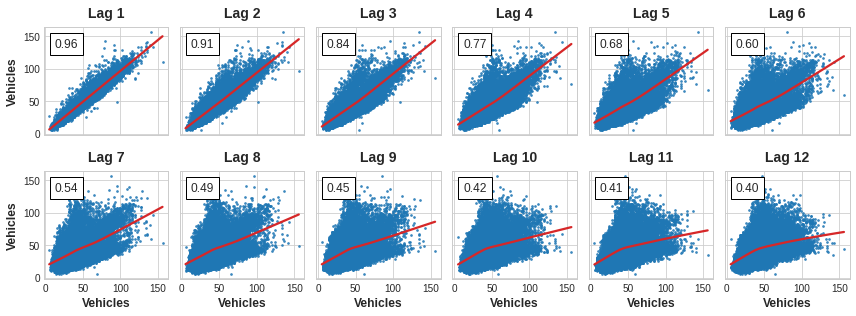

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
_ = plot_pacf(df_auto.Vehicles, lags=12)
_ = plot_acf(df_auto.Vehicles, lags=12)
_ = plot_lags(df_auto.Vehicles, lags=12, nrows=2)

Based in Partial Autocorrelation I selected lag of 1, 2, 3, 4

In [28]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df_auto.Vehicles, lags=4)
X = X.fillna(0.0)

When using lag features, however, we are limited to forecasting time steps whose lagged values are available.

In [29]:
from sklearn.model_selection import train_test_split
# Create target series and data splits
y = df_auto.Vehicles.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

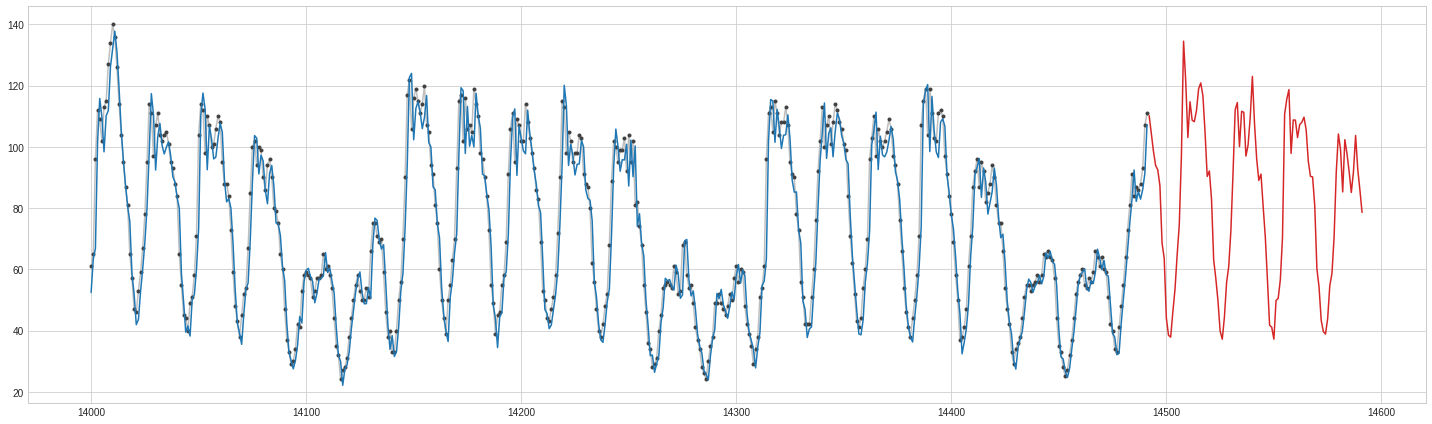

In [30]:
ax = y_train[14000:].plot(**plot_params)
ax = y_test[14000:].plot(**plot_params)
ax = y_pred[14000:].plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features

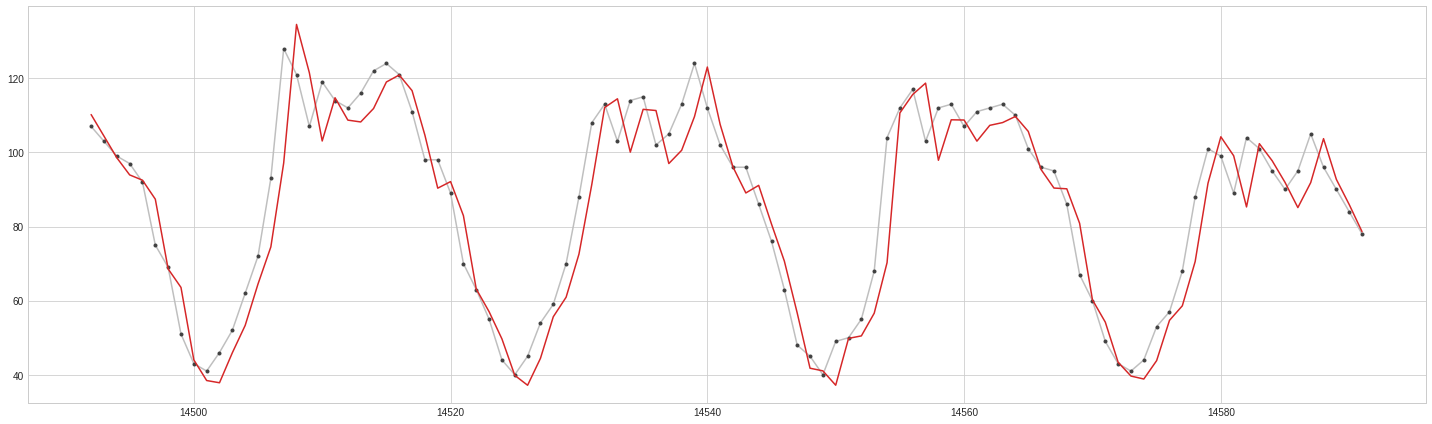

In [31]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

## ARIMA

In [32]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 18.5 MB/s 


In [33]:
from pmdarima import auto_arima
df_arima = data[data["Junction"] == 1][["DateTime", "Vehicles"]]
stepwise_fit = auto_arima(
    df_arima['Vehicles'], 
    trace=True,
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=91399.977, Time=58.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=94927.894, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94031.255, Time=1.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=94203.675, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94925.901, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=93822.614, Time=5.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=93828.681, Time=8.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=93279.119, Time=39.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=93285.645, Time=18.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=93840.016, Time=4.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=93670.052, Time=15.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=93804.733, Time=11.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=92211.889, Time=48.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=91392.343, Time=9.65 sec
 ARIMA(1,1,2)

In [34]:
X_train, x_test = train_test_split(df_arima.Vehicles, test_size=100, shuffle=False)
print(X_train.shape, x_test.shape)

(14492,) (100,)


In [35]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(X_train, order=(2, 1, 2))
model=model.fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                14492
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -45734.410
Date:                Tue, 15 Mar 2022   AIC                          91478.820
Time:                        13:59:36   BIC                          91516.726
Sample:                             0   HQIC                         91491.418
                              - 14492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7167      0.002    949.775      0.000       1.713       1.720
ar.L2         -0.9824      0.002   -560.571      0.000      -0.986      -0.979
ma.L1         -1.6605      0.002   -852.603      0.000      -1.664      -1.657
ma.L2          0.9687      0.002    509.356      0.000       0.965       0.972
sigma2        32.1595      0.192    167.893      0.000      31.784      32.535
===================================================================================
Ljung-Box (L1) (Q):                  54.63   Jarque-Bera (JB):             28879.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

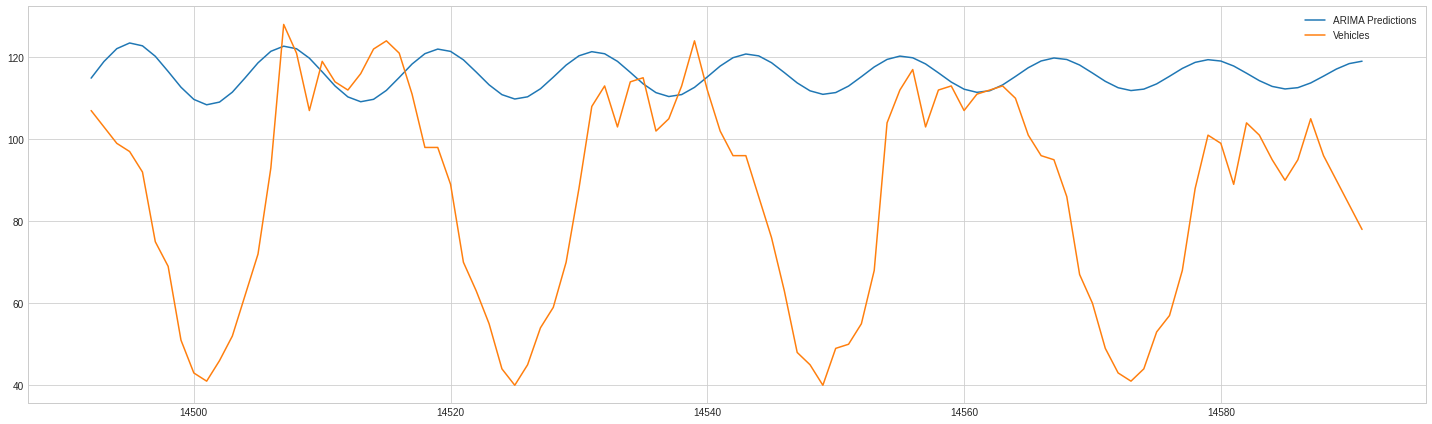

In [37]:
start = len(X_train)
end = len(X_train) + len(x_test) - 1
pred = model.predict(
    start=start,
    end=end, 
    typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
x_test.plot(legend=True)